# Gerekli kütüphaneleri ekledik




In [ ]:
from google.colab import files
files.upload()  # kaggle.json yükle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umutkuzyaka","key":"1fe281c8803329dcec45d9dc703593b8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sid321axn/malicious-urls-dataset
!unzip -o malicious-urls-dataset.zip -d /content/malicious-urls-dataset


Dataset URL: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset
License(s): CC0-1.0
malicious-urls-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  malicious-urls-dataset.zip
  inflating: /content/malicious-urls-dataset/malicious_phish.csv  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

##Veri setini yükledik

#Veri setinini dataframe'e aktardık ve ilk 10 satırı yazdırdık
  

In [ ]:
import pandas as pd


df = pd.read_csv('/content/malicious-urls-dataset/malicious_phish.csv')
df.head(10)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


#Veri kümemizdeki URL tiplerinin dağılımını gösterdik


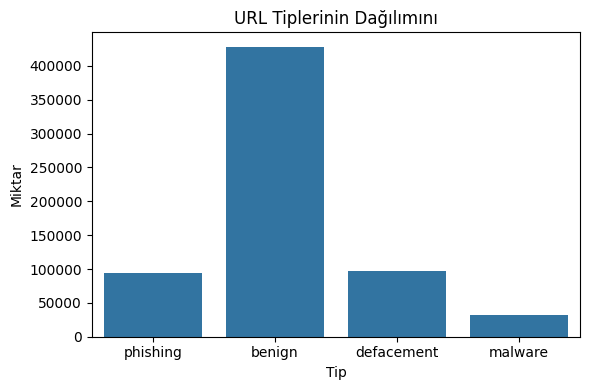

In [ ]:
# ---  Distribution of URL Types ---
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df)
plt.title('URL Tiplerinin Dağılımını')
plt.xlabel('Tip')
plt.ylabel('Miktar')
plt.tight_layout()
plt.show()

#Feature extraction
Veri setindeki urller için belirlediğimiz özellikleri elde etmek için kullandığımız fonksiyon

| Özellik İsmi    | Açıklama                                                                 |
| --------------- | ------------------------------------------------------------------------ |
| `url_length`    | URL'nin toplam karakter uzunluğu.                                        |
| `domain_length` | Domain kısmının (`örnke.com`) uzunluğu.                                |
| `path_length`   | URL'nin yol (path) kısmının uzunluğu. Örn: `/page/index.html`            |
| `num_dots`      | URL'de geçen nokta (`.`) sayısı. Genellikle subdomain sayısını gösterir. |
| `num_slashes`   | URL'de geçen eğik çizgi (`/`) sayısı. URL'nin karmaşıklığını ölçebilir.  |
| `is_https`      | URL `https` ile başlıyorsa `1`, değilse `0`. Güvenli bağlantı kullanımı. |
| `num_params`    | URL'deki parametre sayısı. Örn: `?id=5&ref=abc` → 2 parametre.           |


In [ ]:
def extract_features(url):
    parsed = urlparse(url)
    features = {
        'url_length': len(url),
        'domain_length': len(parsed.netloc),
        'path_length': len(parsed.path),
        'num_dots': url.count('.'),
        'num_slashes': url.count('/'),
        'is_https': int(parsed.scheme == 'https'),
        'num_params': len(parsed.query.split('&')) if parsed.query else 0
    }
    return features

# Feature extraction and concatination
Elde ettiğimiz özellikleri tabloya sütun olarak ekledik
her bir urlyi  fonksiyonla  işleyerek dic  dondurur  ddaha sonra  bu dic pandas Series türüne dönüştürerek sütun  olarak ekler

In [ ]:
features = df['url'].apply(lambda x: pd.Series(extract_features(x)))
df=pd.concat([df, features],axis=1)

#Dataframe  with features
Yeni özelliklerin eklendiği dataframe'in ilk 10 elemanını yazdırdık

In [ ]:
df.head(10)

,url,type,url_length,domain_length,path_length,num_dots,num_slashes,is_https,num_params
0,br-icloud.com.br,phishing,16,0,16,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,35,2,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,31,2,3,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,10,3,3,0,4
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,10,2,3,0,3
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,11,100,2,5,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,0,45,2,6,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,0,19,1,1,0,1
8,http://www.pashminaonline.com/pure-pashminas,defacement,44,22,15,2,3,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45,0,45,1,2,0,0


#Featurelarımız için grafik analizi
Özelliklerimizin dağılımını görmek için grafikle gösterdik

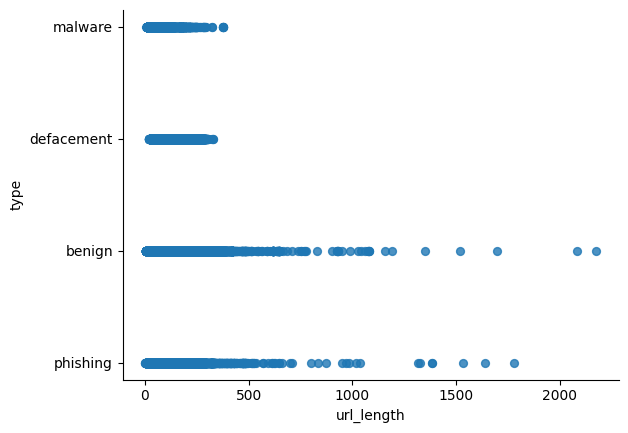

In [ ]:
df.plot(kind='scatter', x='url_length', y='type', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

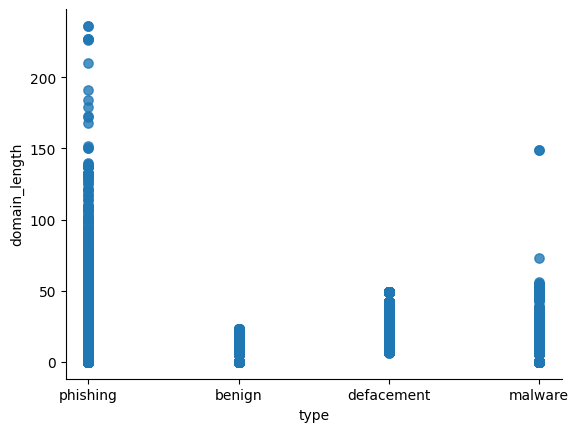

In [ ]:
df.plot(kind='scatter', x='type', y='domain_length', s=45, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

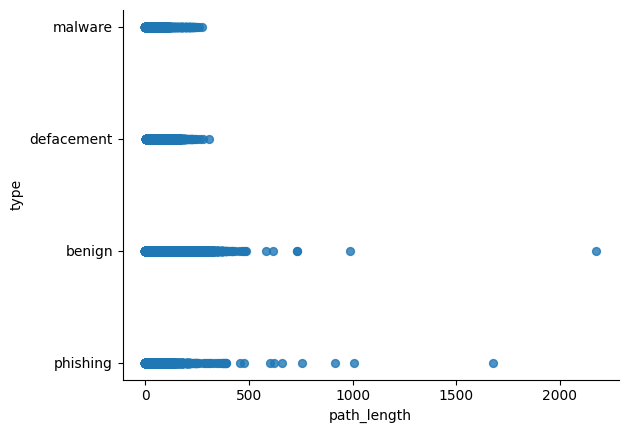

In [ ]:
df.plot(kind='scatter', x='path_length', y='type', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

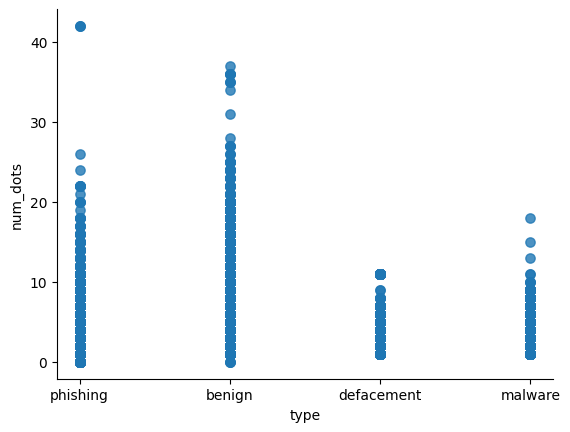

In [ ]:
df.plot(kind='scatter', x='type', y='num_dots', s=45, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

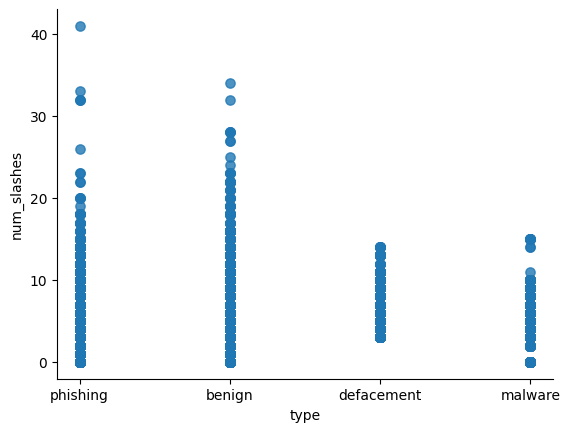

In [ ]:
df.plot(kind='scatter', x='type', y='num_slashes', s=45, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

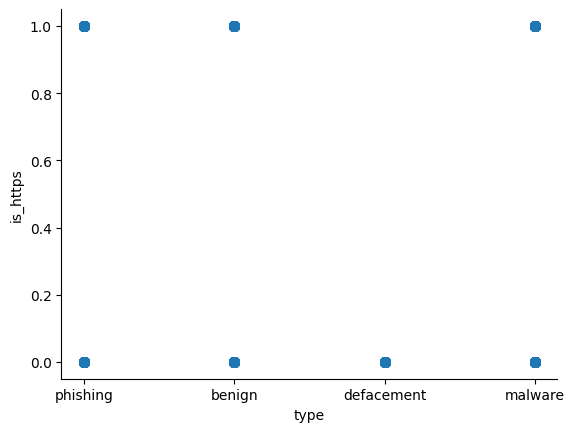

In [ ]:
df.plot(kind='scatter', x='type', y='is_https', s=45, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

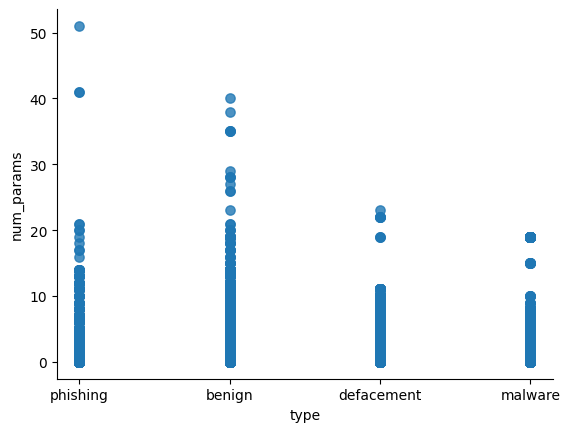

In [ ]:
df.plot(kind='scatter', x='type', y='num_params', s=45, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#**Type etiketini sayısal veriye dönüştürme**
Type etiketini karakter olarak kullanmak karşılaştırma açısından sıkıntılı olacağından 0 1 2 3 değerlerine dönüştürüldü

In [ ]:
le=LabelEncoder()
df['type']=le.fit_transform(df['type'])
df.head()

,url,type,url_length,domain_length,path_length,num_dots,num_slashes,is_https,num_params
0,br-icloud.com.br,3,16,0,16,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,0,35,2,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,0,31,2,3,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,88,21,10,3,3,0,4
4,http://adventure-nicaragua.net/index.php?optio...,1,235,23,10,2,3,0,3


#Model eğitimine hazırlık

  X değerine url ve type hariç sütunlar eklendi.
  Y değerine sadece type sütunu eklendi.
  (Type etiketinin özelliklere göre nasıl bir durumda olduğunu karşılaştırmak için bunu yaptık.)



In [ ]:
X = df.drop(['url', 'type'], axis=1)
y = df['type']

Verilerimizi %80 eğitim %20 test olacak şekilde ayırdık.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN ile Eğitim

##Feature Importance in KNN
Belirlediğimiz parametrelerin eğittiğimiz modellerdeki önemini belirledik ve görselleştirdik.


In [ ]:
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)

result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
for i in result.importances_mean.argsort()[::-1]:
    print(f"{i}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")

1: 0.304 ± 0.001
0: 0.149 ± 0.001
2: 0.134 ± 0.001
4: 0.095 ± 0.001
3: 0.088 ± 0.000
6: 0.021 ± 0.000
5: 0.002 ± 0.000


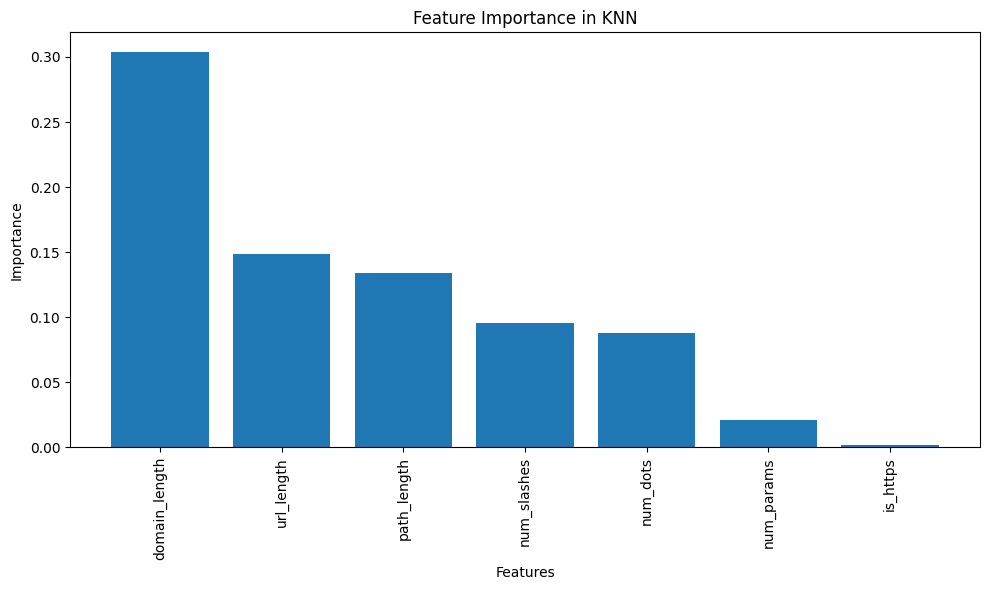

In [ ]:
feature_names = X.columns
indices = [1, 0, 2, 4, 3, 6, 5]  # sıralama
sorted_indices = np.argsort(result.importances_mean)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(result.importances_mean)), result.importances_mean[sorted_indices], align='center')
plt.xticks(range(len(result.importances_mean)), feature_names[sorted_indices], rotation=90)
plt.title('Feature Importance in KNN')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

!!!Normalde ***is_https*** parametresi modelimiz için oldukça önemli bir özelliktir. Çünkü bir URL'nin HTTPS protokolünü kullanması, güvenlik açısından kritik bir faktördür ve modelin doğruluk oranını artırmada etkili olabilir. Ancak mevcut veri setimizde, bazı URL'ler aslında HTTPS olmasına rağmen bu durum göz ardı edilerek yanlış şekilde etiketlenmiş. Yani, verideki HTTPS olup olmadığı bilgisinin doğru şekilde yansıtılmadığı örnekler mevcut. Bu nedenle, modelin öğrenme sürecinde is_https özelliğinin önemi istatistiksel olarak düşük görünmektedir. Fakat, gerçek dünyadaki uygulamalarda HTTPS'in önemi yadsınamaz olduğu için, bu parametreyi veri setimizde tutmaya devam ettik. Gelecekte veri setimiz güncellendiğinde ve etiketleme hataları giderildiğinde, bu özelliğin model performansına daha fazla katkı sağlayacağını düşünüyoruz.



#KNN için GridSearch ile hiperparametre belirleme

In [ ]:
# KNN modelini oluştur
knn = KNeighborsClassifier()


param_grid = {
    'n_neighbors': list(range(3, 15)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

KNN için en iyi hiperparametreleri ve doğruluğu öğrendik.

In [ ]:
# Sonuçlar
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk (cv):", grid_search.best_score_)

En iyi parametreler: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
En iyi doğruluk (cv): 0.9128077043206737


KNN için en iyi hiperparametreler ile modeli eğittik. Model doğruluk oranı ve sınıflandırma raporu çıktısını aldık.

In [ ]:
# Tahminler
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights = 'distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Başarı oranını yazdır
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9135435622202259

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     85778
           1       0.90      0.96      0.93     19104
           2       0.93      0.89      0.91      6521
           3       0.80      0.62      0.70     18836

    accuracy                           0.91    130239
   macro avg       0.89      0.86      0.87    130239
weighted avg       0.91      0.91      0.91    130239



KNN için Confusion Matrix görselleştirdik.

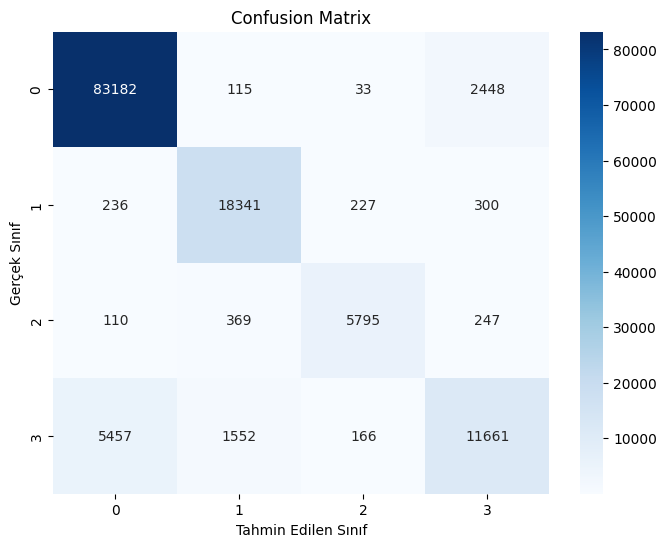

In [ ]:
# Confusion Matrix Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

#**Random Forest ile eğitim**

##**Feature Importance in Random Forest**
Belirlediğimiz parametrelerin eğittiğimiz modellerdeki önemini belirledik ve görselleştirdik.

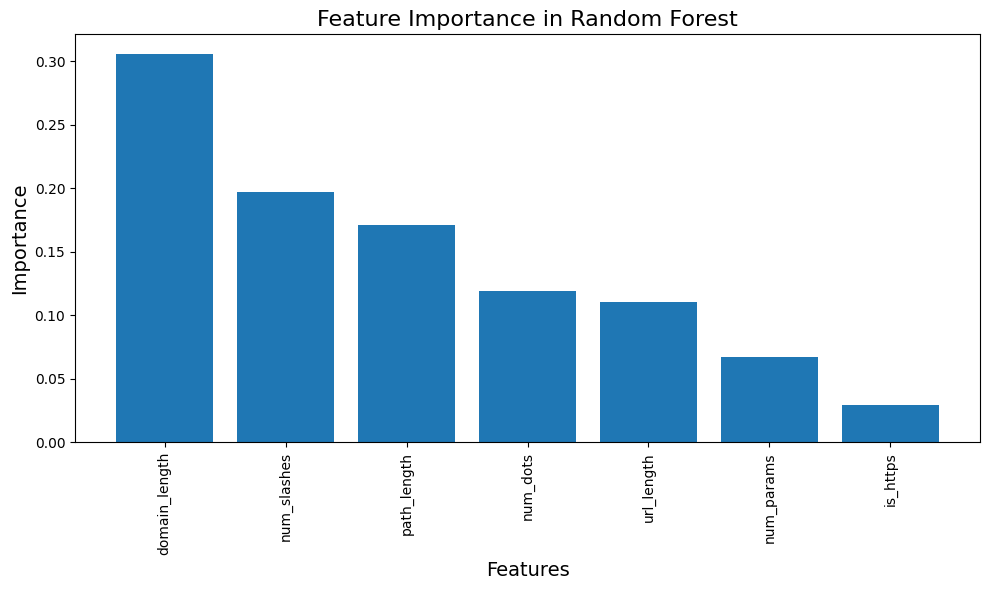

In [ ]:
modelRandomForest = RandomForestClassifier()
modelRandomForest.fit(X_train,y_train)
importance=modelRandomForest.feature_importances_

# Öneme  göre ayırma
indices = np.argsort(importance)[::-1]
feature_names = X.columns

# Create bar chart with sorted features
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices], align='center')
plt.xticks(range(len(importance)), feature_names[indices], rotation=90)
plt.title('Feature Importance in Random Forest', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.tight_layout()
plt.show()

!!!Normalde ***is_https*** parametresi modelimiz için oldukça önemli bir özelliktir. Çünkü bir URL'nin HTTPS protokolünü kullanması, güvenlik açısından kritik bir faktördür ve modelin doğruluk oranını artırmada etkili olabilir. Ancak mevcut veri setimizde, bazı URL'ler aslında HTTPS olmasına rağmen bu durum göz ardı edilerek yanlış şekilde etiketlenmiş. Yani, verideki HTTPS olup olmadığı bilgisinin doğru şekilde yansıtılmadığı örnekler mevcut. Bu nedenle, modelin öğrenme sürecinde is_https özelliğinin önemi istatistiksel olarak düşük görünmektedir. Fakat, gerçek dünyadaki uygulamalarda HTTPS'in önemi yadsınamaz olduğu için, bu parametreyi veri setimizde tutmaya devam ettik. Gelecekte veri setimiz güncellendiğinde ve etiketleme hataları giderildiğinde, bu özelliğin model performansına daha fazla katkı sağlayacağını düşünüyoruz.

##Random Forest için RandomSearch ile Hiperparametre Optimizasyonu

In [ ]:
rf=RandomForestClassifier()

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt'],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 30, 50, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

Random Forest için en iyi hiperparametreleri ve doğruluğu öğrendik.

In [ ]:
print("Random forest için  ")
print("En iyi hiperparametreler :",random_search.best_params_)
print("En iyi doğruluk (cv):", random_search.best_score_)

Random forest için  
En iyi hiperparametreler : {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
En iyi doğruluk (cv): 0.9229468340937056


Random Forest için en iyi hiperparametreler ile modeli eğittik. Model doğruluk oranı ve sınıflandırma raporu çıktısını aldık.

In [ ]:
rf=RandomForestClassifier(n_estimators = 500, min_samples_split =5, min_samples_leaf = 1, max_features = 'sqrt', max_depth =30, bootstrap =True)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
# Sonuçlar
print("Model Doğruluk Oranı:", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

Model Doğruluk Oranı: 0.9229800597363309

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     85778
           1       0.93      0.97      0.95     19104
           2       0.95      0.89      0.92      6521
           3       0.79      0.69      0.74     18836

    accuracy                           0.92    130239
   macro avg       0.90      0.88      0.89    130239
weighted avg       0.92      0.92      0.92    130239



Random Forest için Confusion Matrix görselleştirdik.

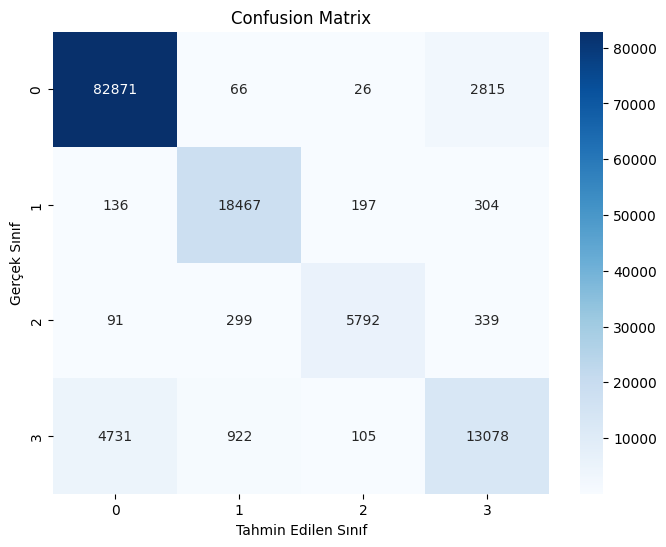

In [ ]:
# Confusion Matrix Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

##KNN  ve Random Forest karşılaştırması
**Random Forest**  

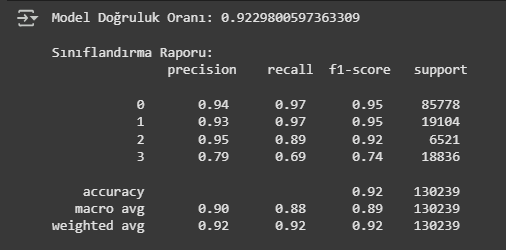

**KNN**

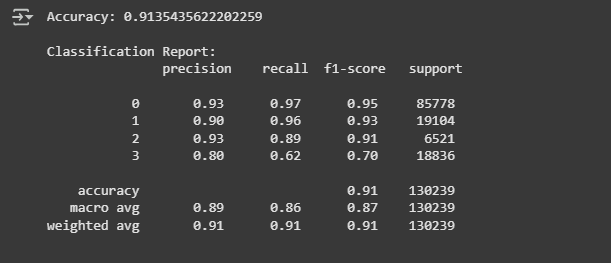

*  Random Forest hemen her metrikte daha iyi performans gösteriyor.
*  Random Forest Yaklaşık %1 daha yüksek doğruluk oranına sahip
*  Her iki  modelde de 3  ile etiketlenmiş phishing sınfının precision,recall  ve f1 score değeri en düşükte
